In [43]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, make_scorer,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder



from xgboost import XGBClassifier  # Assuming you are using XGBoost for classification; use XGBRegressor for regression
import xgboost as xgb 

from sklearn.metrics import confusion_matrix

import pprint
from tabulate import tabulate

from sklearn import linear_model

from imblearn.over_sampling import SMOTE
# if there is an error, solve by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''


# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

# Data Pre-Processing and Cleaning 

1. Removed variables that are redundant and uncorrelated to the dependent variable such as ID, year. 
2. Removed the NAs. 

In [159]:

# 1. Upload the dataset 
df = pd.read_csv('Loan_Default.csv')
# 2. remove some variables that are redundant such as year, ID
# 3. Removed Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# 4. Removed open credit , secured by, total units : only has one value or too few observations 
df = df.drop(['year', 'ID', 'loan_type', 'loan_purpose', 'Interest_rate_spread', 
              'rate_of_interest', 'open_credit','Upfront_charges','construction_type', 
              'Secured_by', 'Security_Type','total_units'], axis=1)

# 5. Removed NAs 
df = df.dropna(subset=["property_value"])
df = df.dropna(subset=["term"])
df = df.dropna(subset=["loan_limit"])
df = df.dropna(subset=["approv_in_adv"])
df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["income"])
# Drop rows where sex is not available 
df = df.drop(df[df['Gender'] == 'Not Available'].index)

# Check and remove outliers 

loan_amount          Axes(0.125,0.786098;0.133621x0.0939024)
term              Axes(0.285345,0.786098;0.133621x0.0939024)
property_value     Axes(0.44569,0.786098;0.133621x0.0939024)
income            Axes(0.606034,0.786098;0.133621x0.0939024)
Credit_Score      Axes(0.766379,0.786098;0.133621x0.0939024)
LTV                  Axes(0.125,0.673415;0.133621x0.0939024)
Status            Axes(0.285345,0.673415;0.133621x0.0939024)
dtir1              Axes(0.44569,0.673415;0.133621x0.0939024)
dtype: object

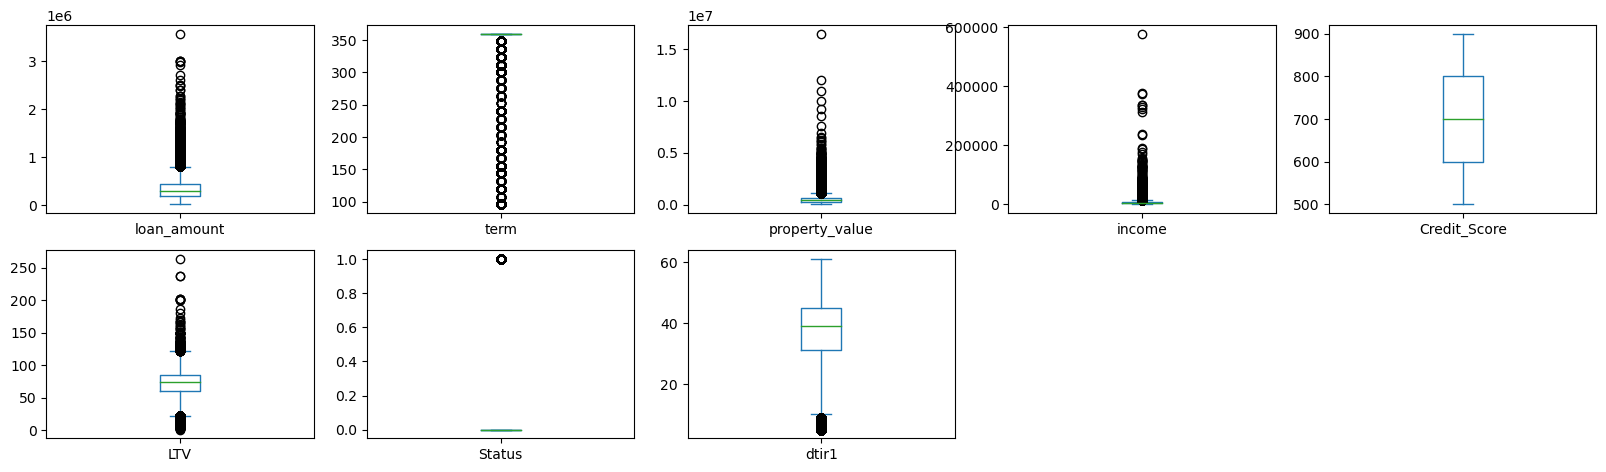

In [160]:
df.plot(kind="box",subplots=True,layout=(7,5),figsize=(20,20))


In [161]:
# Select only numeric columns
df1 = df.drop(["Status"], axis=1)
numeric_df = df1.select_dtypes(include=[np.number])

# Calculate quartiles and IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR)))

# Remove outliers
df = df[~outliers.any(axis=1)]

# Check the number of outliers removed for each feature
print("Number of outliers removed for each feature:")
print(outliers.sum())

Number of outliers removed for each feature:
loan_amount        1422
term              22886
property_value     5354
income             5625
Credit_Score          0
LTV                1932
dtir1              1943
dtype: int64


## Imbalanced dataset 
Now we check if the dataset is imbalanced or not. As shown below, it is heavily imbalanced where the minority class (default) has fewer observations than the non-defaulters. Now we take a note that we need to deal with this when the model is tuning for hyperparameters and when training the model for Out-of-Sample (OOS) testing. 

In [162]:
print(df['Status'].value_counts())

0    74266
1    13953
Name: Status, dtype: int64


## Dealing with categorical values 

We deal with categorical value by turning it into dummy variable. 

Method from : https://towardsdatascience.com/robust-one-hot-encoding-930b5f8943af 

In [163]:
# We turn these columns into dummy variables since they are categorical and drop the original column in the dataframe 
categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'occupancy_type',
        'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region']

# Initialize the encoder
enc = OneHotEncoder(handle_unknown='ignore', drop='first')

# Fit and transform the data
enc_data = enc.fit_transform(df[categorical_columns])

# Get feature names
feature_names = enc.get_feature_names_out(categorical_columns)

# Convert to DataFrame
enc_df = pd.DataFrame(enc_data.toarray(), 
                          columns=feature_names)

df = df.reset_index()

for i in categorical_columns: 
    df = df.drop(i,axis=1)

# Concatenate with the numerical data
df = pd.concat([df, enc_df], axis=1)

## Check for NAs

In [164]:
# Check for missing values
missing_values = df.isna().sum()

# Filter and print only columns with missing values
missing_columns = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Columns with missing values:")
    print(missing_columns)
else:
    print("No missing values found in the DataFrame.")

No missing values found in the DataFrame.


# Checking Correlation between values 

We check for multi-colinearity between variables. There are no particularly significant multi-colinearly between the variables as we indicate that correlation higher than 0.8 is high. 

In [165]:
correlation_matrix = df.corr()

# Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Check for high absolute correlation coefficients
threshold = 0.8 
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


Highly correlated pairs:
property_value and loan_amount: 0.8568997582848178


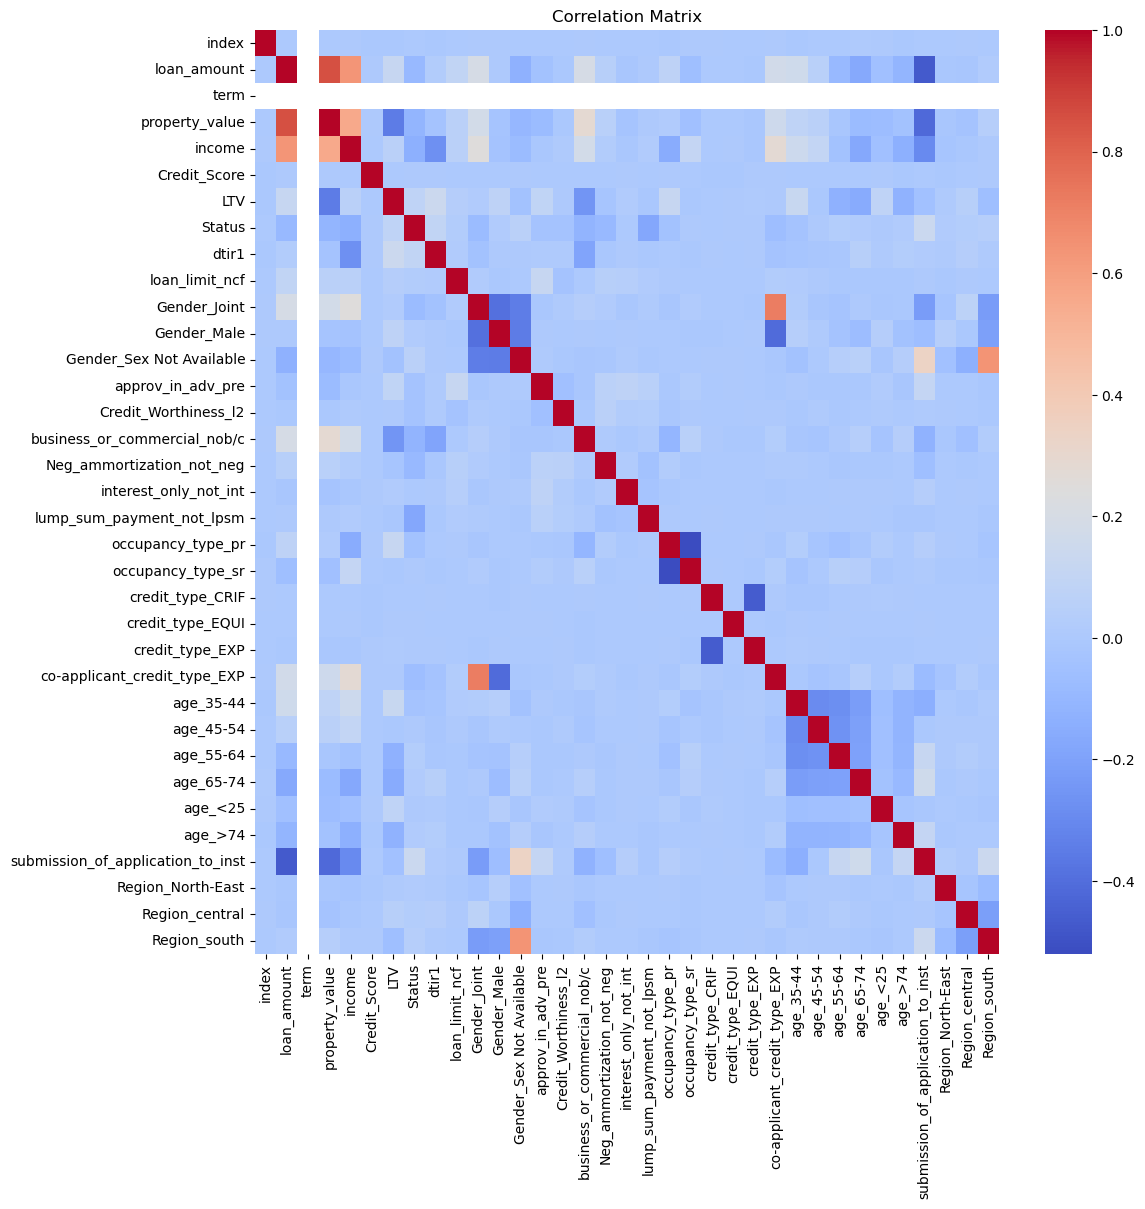

In [166]:
# Plot correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

A couple of things we can take note from the heatmap is : 
1. There is correlation between property value and loan amount which is reasonable given that higher priced property would require higher loans. 
2. The "term" variable is now redundant so we're going to remove it. 
   

In [167]:
df = df.drop(['term'], axis=1)

# Split Train Test dataset



In [168]:
# define X and y variables as dataframe 
y = df['Status']
X = df.drop('Status',axis=1)
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

# Standardize features

In [169]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_OOS_test = scaler.transform(X_OOS_test)

## Over Sampling using SMOTE

Since we know previously that our data is hihgly imbalanced, we use SMOTE to help us decrease the bias and to help the model learn to identify the minority class. 


In [170]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)

## Setup K-Fold Cross Validation 

In [171]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# Fine tune hyperparameters using Cross Validation 

We will fine tune the hyperparameters of the model with on cross validation using K-Folds 5 splits. 

## Why use Recall instead of standard MSE? 

The reason why recall a more important matric than standard accuracy and precision is because in credit default predictions, false negatives are what we are most concerned with. In this case, it is those who were predicted as non-defaulters who actually are defaulters. These clients are what is causing the bank or lenders financial distress as they will default on their loans and cannot repay their debt. 

### Model 1 : Logistic Regression with LASSO and Ridge Regression
#### 1.1 Cross Validation for Logistic Regression with LASSO 

In [172]:
# recall_scorer = make_scorer(recall_score)

lasso_logistic = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)

# Define the pipeline with SMOTE
pipeline = Pipeline([
    ('sampling', SMOTE(random_state=42)),
    ('lasso_logistic', lasso_logistic)
])

# Define the grid of parameters to search
param_grid = {
    'lasso_logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Recall):", best_score)

Best Parameters: {'lasso_logistic__C': 0.1}
Best Score (Recall): 0.648548887978323


The best parameters for Lasso Regression is lambda = 0.1. 

In [173]:
lasso_logistic = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=0.1)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
lasso_logistic.fit(X_smote, y_smote)
y_pred = lasso_logistic.predict(X_OOS_test)
print("Recall : " , recall_score(y_OOS_test, y_pred))
print("Precision : " , precision_score(y_OOS_test, y_pred))
print("Accuracy : " , accuracy_score(y_OOS_test, y_pred))


Recall :  0.6443370165745856
Precision :  0.2707486941381312
Accuracy :  0.6567671729766493


# Model 2 : Random Forest

### 2.1 Cross Validation for Random Forest 

In [193]:
rf_classifier = RandomForestClassifier(random_state=42)

# Define the pipeline with SMOTE
pipeline = Pipeline([
    ('sampling', SMOTE(random_state=42, sampling_strategy=0.25)),
    ('rf_classifier', rf_classifier)
])

# Define the grid of parameters to search
param_grid = {
    'rf_classifier__n_estimators': [10, 30, 50, 100],  # Number of trees in the forest
    'rf_classifier__max_depth': [1, 3, 5, 10, 20],       # Maximum depth of the tree
    # 'rf_classifier__min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    # 'rf_classifier__min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Recall):", best_score)

Best Parameters: {'rf_classifier__max_depth': 20, 'rf_classifier__n_estimators': 100}
Best Score (Recall): 0.8630109812256463


In [201]:
model = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=20)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
model.fit(X_smote, y_smote)
y_pred = model.predict(X_OOS_test)
print("Recall : " , recall_score(y_OOS_test, y_pred))
print("Precision : " , precision_score(y_OOS_test, y_pred))
print("Accuracy : " , accuracy_score(y_OOS_test, y_pred))

Recall :  0.4844613259668508
Precision :  0.39146205357142855
Accuracy :  0.7917705735660848


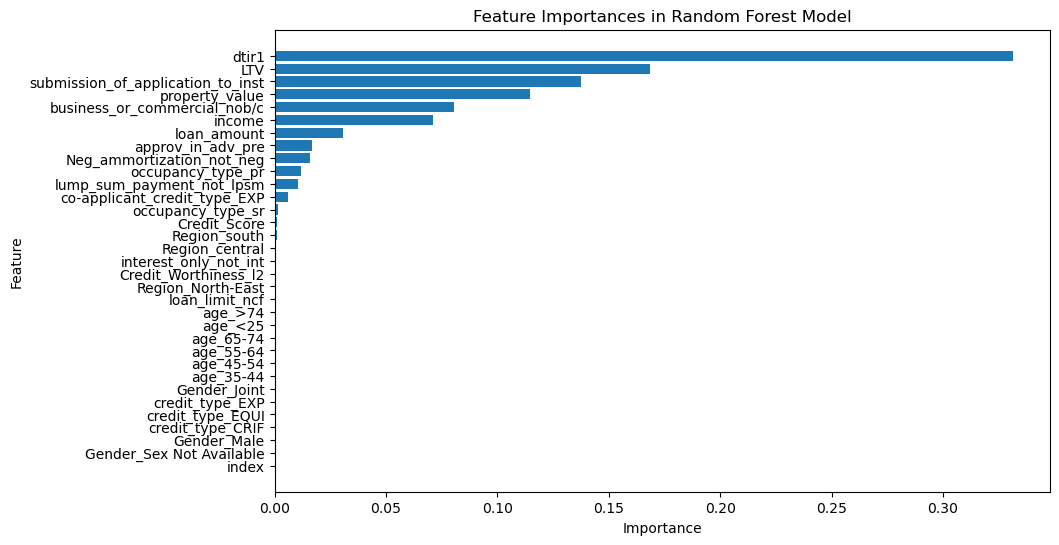

In [182]:
# Train the Random Forest model
model = RandomForestClassifier(n_estimators=5, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns  # Assuming X is a DataFrame

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

The best parameters for random forest are 3 max depth and 400 estimators. 

# Model 3 : KNN 

### 3.1 Cross Validation for KNN 

In [178]:
# Define the KNN classifier
knn_classifier = KNeighborsClassifier()

# Define SMOTE
smote = SMOTE(random_state=42)

# Define pipeline with SMOTE and KNN
pipeline = Pipeline([
    ('sampling', smote),
    ('knn_classifier', knn_classifier)
])

# Define the grid of parameters to search
param_grid = {
    'knn_classifier__n_neighbors': [1,5,10,20,50,100,200,500],
}

# Define recall scorer
recall_scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=recall_scorer)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Recall):", best_score)

Best Parameters: {'knn_classifier__n_neighbors': 200}
Best Score (Recall): 0.6844542289375087


In [203]:
model = KNeighborsClassifier(n_neighbors=200)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
model.fit(X_smote, y_smote)
y_pred = model.predict(X_OOS_test)
print("Recall : " , recall_score(y_OOS_test, y_pred))
print("Precision : " , precision_score(y_OOS_test, y_pred))
print("Accuracy : " , accuracy_score(y_OOS_test, y_pred))

Recall :  0.6740331491712708
Precision :  0.25626887225941974
Accuracy :  0.6254250736794378


The best hyper-parameter for the number of neighbors is 200. 

# Model 4 : XGBoost

In [226]:
# Initialize XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define pipeline with SMOTE and KNN
pipeline = Pipeline([
    ('sampling', smote),
    ('classifier', xgb)
])

# # Define the hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__colsample_bytree': [0.3, 0.5, 0.7, 0.9]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='recall', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters found: ", best_params)

# Best score
best_score = grid_search.best_score_
print("Best cross-validation score: ", best_score)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparameters found:  {'classifier__colsample_bytree': 0.9, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 1, 'classifier__n_estimators': 200}
Best cross-validation score:  0.8051025899599488


In [227]:
model = XGBClassifier(objective='binary:logistic', colsample_bytree=0.7 ,random_state=42,n_estimators=100,max_depth=1,learning_rate=0.01)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
model.fit(X_smote, y_smote)
y_pred = model.predict(X_OOS_test)
print("Recall : " , recall_score(y_OOS_test, y_pred))
print("Precision : " , precision_score(y_OOS_test, y_pred))
print("Accuracy : " , accuracy_score(y_OOS_test, y_pred))


Recall :  0.7800414364640884
Precision :  0.2083948339483395
Accuracy :  0.4775561097256858


### 6.1 Confusion Matrix for XGBoost 

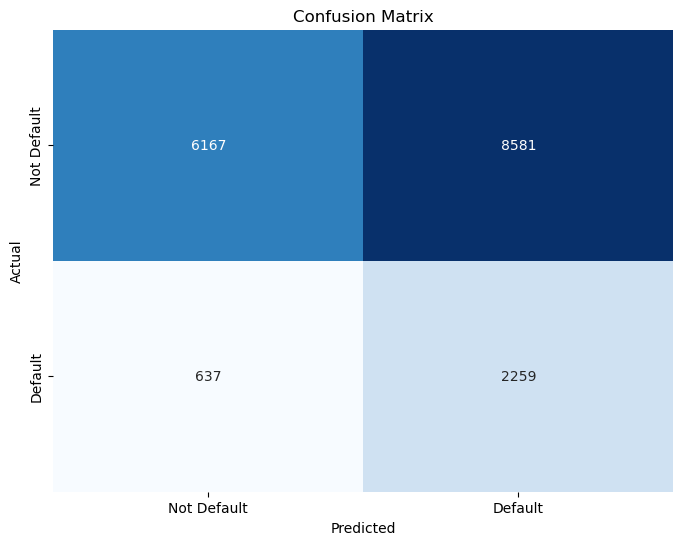

In [228]:
# Compute the confusion matrix
cm = confusion_matrix(y_OOS_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()